In [1]:
# %%
from jacho.layers.reservoirs import RandomReservoir
from jacho.models.generic import GenericEchoState
from jacho.layers.output import Residual
from jacho.training.training import ridge
from jacho.data.KS import KS
from jax import random
import numpy as np
import jax.numpy as jnp
import matplotlib.pyplot as plt

key = random.PRNGKey(42)

%load_ext autoreload 
%autoreload 2

In [2]:
# Setting up our dataset; similar to jonathans
L = 22 / (2 * np.pi)  # length
N = 100  # space discretization step
dt = 0.25  # time discretization step
N_train = 10000
N_test = 2000
N_init = 1000  # remove the initial points
tend = (N_train + N_test + N_init) * dt

np.random.seed(1)
dns = KS(L=L, N=N, dt=dt, tend=tend)
dns.simulate()

In [3]:
# Prepping train and test matrices
# inputs need to be size [time_steps, samples, spatial_points]
# i.e. here they are [10000, 1, 100]
u = np.expand_dims(dns.uu, axis=1)
_, u_train, u_test, _ = np.split(u / np.sqrt(N), 
                                     [N_init, 
                                     (N_init + N_train), 
                                     (N_init + N_train + N_test)], axis=0)

In [4]:
# Setting up model
n_reservoir = 10000
reservoir_args = (0.4, 0.9, 0.4) #input_scale, reservoir_scale, bias_scale

n_out = u_train.shape[-1]
norm_factor = 1.1 * jnp.sqrt(n_out / n_reservoir)
output_layer_args = (norm_factor, )

model = GenericEchoState(n_reservoir, RandomReservoir, reservoir_args,
                  n_out, Residual, output_layer_args)


key = random.PRNGKey(42)
state = model.initialize_state(key, n_reservoir)
params = model.init(key, state, u_train[0]) # initializing the parameters and state

In [5]:
%%time
# Running the reservoir using method = model.run_reservoir
# Returns a (final_state, intermediate_states) tuple
new_state, intermediate_states = model.apply(params, state, u_train[:-1], method=model.run_reservoir)

CPU times: user 5.64 s, sys: 4.52 s, total: 10.2 s
Wall time: 10.1 s


In [6]:
intermediate_states = intermediate_states.squeeze()

In [7]:
intermediate_states.shape

(9999, 10000)

In [8]:
K_train = jnp.pad(jnp.dot(intermediate_states, intermediate_states.T), ((1, 0), (1, 0)))

In [9]:
K_train.shape

(10000, 10000)

In [10]:
jnp.linalg.cholesky(K_train + 1e-4 * jnp.eye(K_train.shape[0]))

DeviceArray([[0.01      , 0.        , 0.        , ..., 0.        ,
              0.        , 0.        ],
             [0.        , 0.5375312 , 0.        , ..., 0.        ,
              0.        , 0.        ],
             [0.        , 0.47272882, 0.3864939 , ..., 0.        ,
              0.        , 0.        ],
             ...,
             [0.        , 0.08822858, 0.05125438, ..., 0.01164774,
              0.        , 0.        ],
             [0.        , 0.08991057, 0.05256496, ..., 0.00420062,
              0.01163871, 0.        ],
             [0.        , 0.09105873, 0.05347554, ..., 0.00469637,
              0.00417769, 0.01163632]], dtype=float32)

So we require and offset to make it positive semi-definite.

Now to train:

In [11]:
%%time
# Training; we give the model, state and params
# It runs the reservoir and returns the state after running training and the updated params
end_of_train_state, params = ridge(model, params, state, u_train, renorm_factor=norm_factor, alpha=1e-2)

CPU times: user 9.47 s, sys: 4.59 s, total: 14.1 s
Wall time: 14.4 s


In [12]:
W_out = params['params']['output_layer']['Dense_0']['kernel']

In [13]:
%%time
# Extrapolate
# We start with the point after training and recursively predict
n_predict_steps = 2000
end_of_predict_state, (prediction, predicted_states) = model.apply(params, end_of_train_state, u_train[-1], n_predict_steps)

CPU times: user 1.22 s, sys: 957 ms, total: 2.17 s
Wall time: 2.17 s


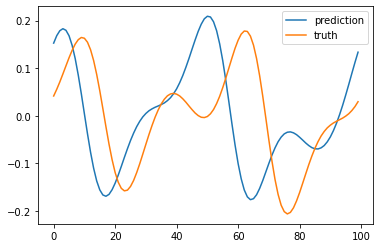

In [14]:
frame = 200
plt.plot(prediction[frame, :].squeeze(), label='prediction')
plt.plot(u_test[frame, :].squeeze(), label='truth')

plt.legend()

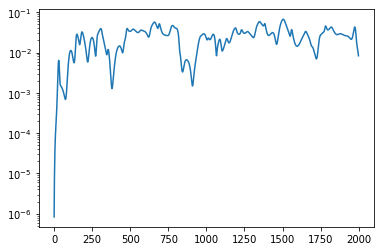

In [15]:
plt.semilogy(jnp.mean(((prediction - u_test)**2).squeeze(), axis=1))

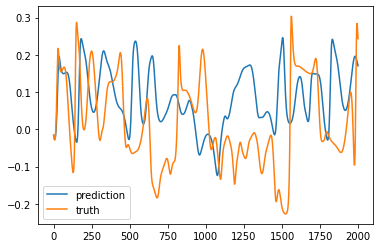

In [16]:
idx = 50
plt.plot(prediction.squeeze()[:, idx], label='prediction')
plt.plot(u_test.squeeze()[:, idx], label='truth')

plt.legend()

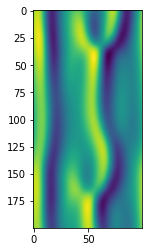

In [17]:
plt.imshow(prediction.squeeze()[:200])

In [18]:
predicted_states = predicted_states.squeeze()

In [19]:
K_test = jnp.dot(predicted_states, predicted_states.T)
K_test_diag = jnp.diag(K_test)

In [20]:
K_test = jnp.pad(jnp.dot(predicted_states, intermediate_states.T), ((0, 0), (1, 0)))

In [21]:
K_test.shape

(2000, 10000)

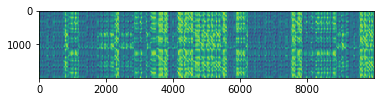

In [22]:
plt.imshow(K_test)

Lets also get the 'true' K:

In [25]:
u_test.shape

(2000, 1, 100)

In [26]:
%%time
# Running the reservoir using method = model.run_reservoir
# Returns a (final_state, intermediate_states) tuple
_, intermediate_states = model.apply(params, state, jnp.concatenate([u_train, u_test])[:-1], method=model.run_reservoir)
K_true = jnp.pad(jnp.dot(intermediate_states.squeeze(), intermediate_states.squeeze().T), ((1, 0), (1, 0)))

CPU times: user 11.5 s, sys: 5.68 s, total: 17.2 s
Wall time: 17.3 s


In [27]:
jnp.save("K_baseline_train.npy", K_train)
jnp.save("K_baseline_test.npy", K_test)
jnp.save("K_true.npy", K_true)

jnp.save("u_train.npy", u_train.squeeze())
jnp.save("u_test.npy", u_test.squeeze())

jnp.save("baseline_W_out.npy", W_out)